# Concise Implementation of Multi-GPU Computation

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

Initialize model parameters on multiple GPUs


In [2]:
net = d2l.resnet18(10)
ctx = d2l.try_all_gpus()
net.initialize(init=init.Normal(sigma=0.01), ctx=ctx)

Test

In [3]:
x = np.random.uniform(size=(4, 1, 28, 28))
gpu_x = gluon.utils.split_and_load(x, ctx)
net(gpu_x[0]), net(gpu_x[1])

(array([[ 5.48149364e-06, -8.33710089e-07, -1.63167692e-06,
         -6.36740765e-07, -3.82161761e-06, -2.35140669e-06,
         -2.54695851e-06, -9.47824219e-08, -6.90335582e-07,
          2.57562374e-06],
        [ 5.47108630e-06, -9.42463600e-07, -1.04940591e-06,
          9.80820687e-08, -3.32518266e-06, -2.48629135e-06,
         -3.36428002e-06,  1.04560286e-07, -6.10012194e-07,
          2.03278501e-06]], ctx=gpu(0)),
 array([[ 5.6176350e-06, -1.2837600e-06, -1.4605525e-06,  1.8302978e-07,
         -3.5511648e-06, -2.4371018e-06, -3.5731791e-06, -3.0974837e-07,
         -1.1016566e-06,  1.8909888e-06],
        [ 5.1418701e-06, -1.3729926e-06, -1.1520079e-06,  1.1507450e-07,
         -3.7372806e-06, -2.8289705e-06, -3.6477188e-06,  1.5781586e-07,
         -6.0733169e-07,  1.9712008e-06]], ctx=gpu(1)))

Evaluating accuracy on multiple GPUs

In [4]:
def evaluate_accuracy_gpus(net, data_iter):
    # Query the list of devices.
    ctx_list = list(net.collect_params().values())[0].list_ctx()
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for features, labels in data_iter:
        Xs, ys = d2l.split_batch(features, labels, ctx_list)
        pys = [net(X) for X in Xs]  # run in parallel
        metric.add(sum(float(d2l.accuracy(py, y)) for py, y in zip(pys, ys)), 
                   labels.size)
    return metric[0]/metric[1]

The training function

In [5]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx_list = [d2l.try_gpu(i) for i in range(num_gpus)]
    net.initialize(init=init.Normal(sigma=0.01),
                   ctx=ctx_list, force_reinit=True)
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        timer.start()
        for features, labels in train_iter:
            Xs, ys = d2l.split_batch(features, labels, ctx_list)
            with autograd.record():
                ls = [loss(net(X), y) for X, y in zip(Xs, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
        npx.waitall()
        timer.stop()
        animator.add(epoch+1, (evaluate_accuracy_gpus(net, test_iter),))
    print('test acc: %.2f, %.1f sec/epoch on %s' % (
        animator.Y[0][-1], timer.avg(), ctx_list))

Use a single GPU for training

test acc: 0.93, 13.2 sec/epoch on [gpu(0)]


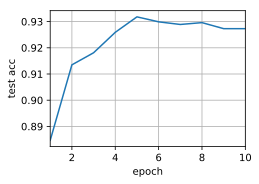

In [6]:
train(num_gpus=1, batch_size=256, lr=0.1)

Use 2 GPUs for training

test acc: 0.92, 7.3 sec/epoch on [gpu(0), gpu(1)]


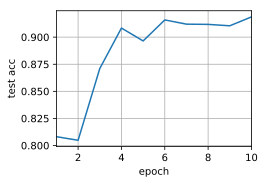

In [7]:
train(num_gpus=2, batch_size=512, lr=0.2)